<a href="https://colab.research.google.com/github/VickyBachu/Melanoma_Detection_Assignment/blob/main/VickyBachu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

#### Data Reading/ Data Understanding

### Importing important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## Mounting the google drive to access the data :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types in both train and test directories. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Setting the path for train and test images dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin_cancer_ISIC/Test')

In [ ]:
# Count of the number of images in each set

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

## Creating Dataset

In [ ]:
## Creating train dataset using tf.keras.preprocessing.image_dataset_from_directory
## with seed=123 
## and resizing the images to the size of img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Creating validation dataset using tf.keras.preprocessing.image_dataset_from_directory
## with seed=123 
## and resizing the images to the size of img_height*img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List of all the classes of skin cancer and store them in class_names attribute list in alphabetical order

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
## visualization of one instance of all the nine classes present in the dataset

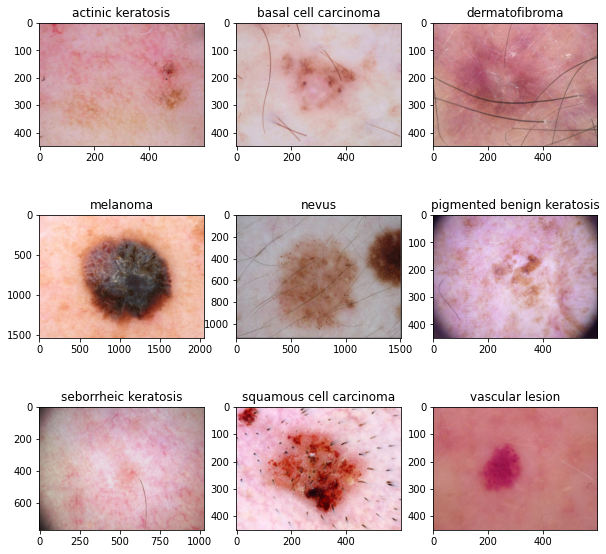

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
## Visualization using training or validation data

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset using ```layers.experimental.preprocessing.Rescaling``` which is used to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
## Importing important layer libraries

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Selecting an appropirate optimiser and loss function for model training 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 723s 3s/step - loss: 2.0380 - accuracy: 0.2143 - val_loss: 1.9296 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8764 - accuracy: 0.3047 - val_loss: 1.7750 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8873 - accuracy: 0.3103 - val_loss: 1.7834 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7397 - accuracy: 0.3460 - val_loss: 1.7460 - val_accuracy: 0.3311
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7170 - accuracy: 0.3996 - val_loss: 1.6189 - val_accuracy: 0.4206
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.6048 - accuracy: 0.4174 - val_loss: 1.5909 - val_accuracy: 0.4206
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5656 - accuracy: 0.4314 - val_loss: 1.5163 - val_accuracy: 0.4720
Epoch 8/20
56/56 [======

### Visualizing training results

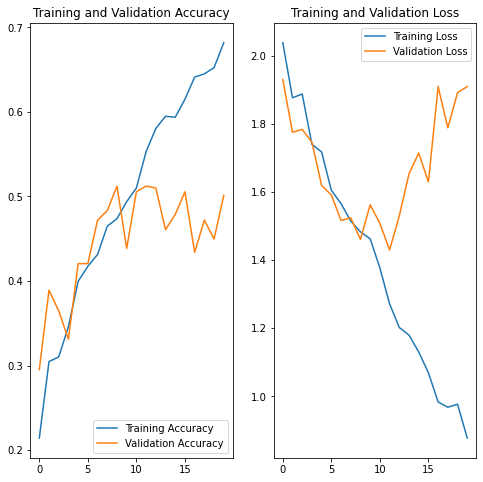

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings after the model fit to check wether the model is overfit or underfit


**Finding on the first base model**

- The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

- The accuracy is just around 75-80% because there are enough features to remember the pattern.

- But again, it's too early to comment on the overfitting & underfitting debate



# Data Augmentation

In [ ]:
# Selecting an appropriate data augumentation strategy, after analysed the model fit history for presence of underfit or overfit
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

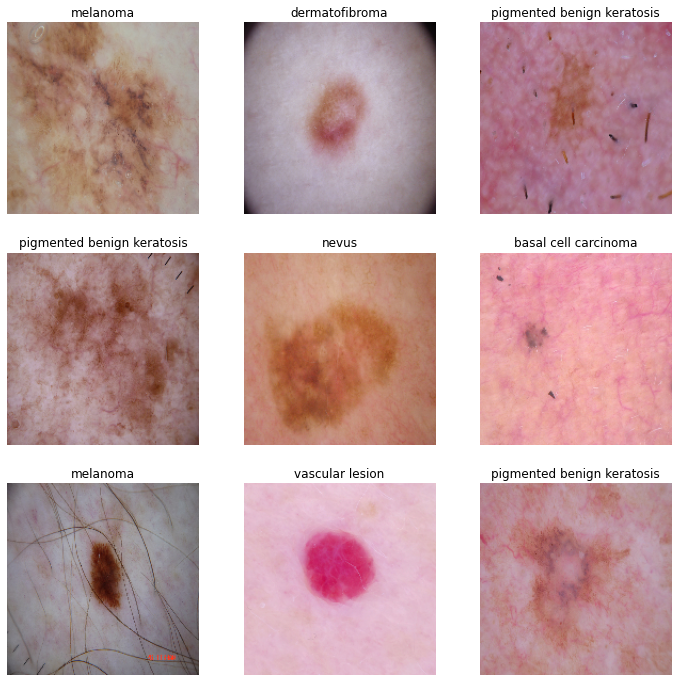

In [ ]:
# Visualizing how augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model


In [ ]:
## Accessing Dropout layer, as there is an evidence of overfitting in findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Train model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 92ms/step - loss: 2.0723 - accuracy: 0.2081 - val_loss: 2.0102 - val_accuracy: 0.2013
Epoch 2/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9011 - accuracy: 0.3019 - val_loss: 2.0559 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 5s 89ms/step - loss: 1.6672 - accuracy: 0.4157 - val_loss: 1.7118 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 5s 88ms/step - loss: 1.6493 - accuracy: 0.4107 - val_loss: 1.5527 - val_accuracy: 0.4452
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5647 - accuracy: 0.4453 - val_loss: 2.0954 - val_accuracy: 0.3199
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6491 - accuracy: 0.4230 - val_loss: 1.5747 - val_accuracy: 0.4273
Epoch 7/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5414 - accuracy: 0.4420 - val_loss: 1.7415 - val_accuracy: 0.3557
Epoch 8/20
56/56 [======

### Visualizing the results

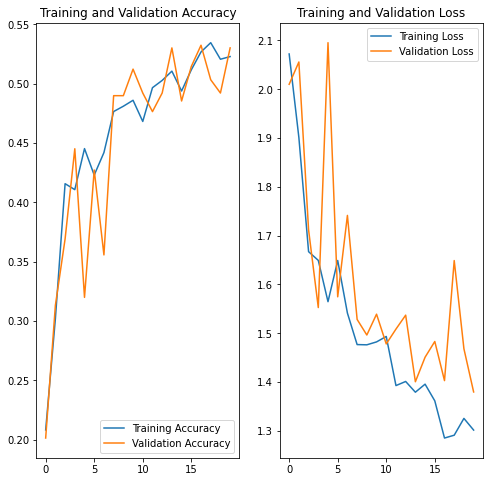

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Fndings after the model fit, to check if there is an evidence of model overfit or underfit. Also validaying if there is some improvement now as compared to the previous model run

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation 

- We can increase the epochs to increase the accuracy so it's too early for judgement 

# Class Distribution

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
1,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
2,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
3,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
4,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
2235,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
2236,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
2237,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion


In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
1,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
2,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
3,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
4,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
2235,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
2236,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
2237,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion


<BarContainer object of 9 artists>

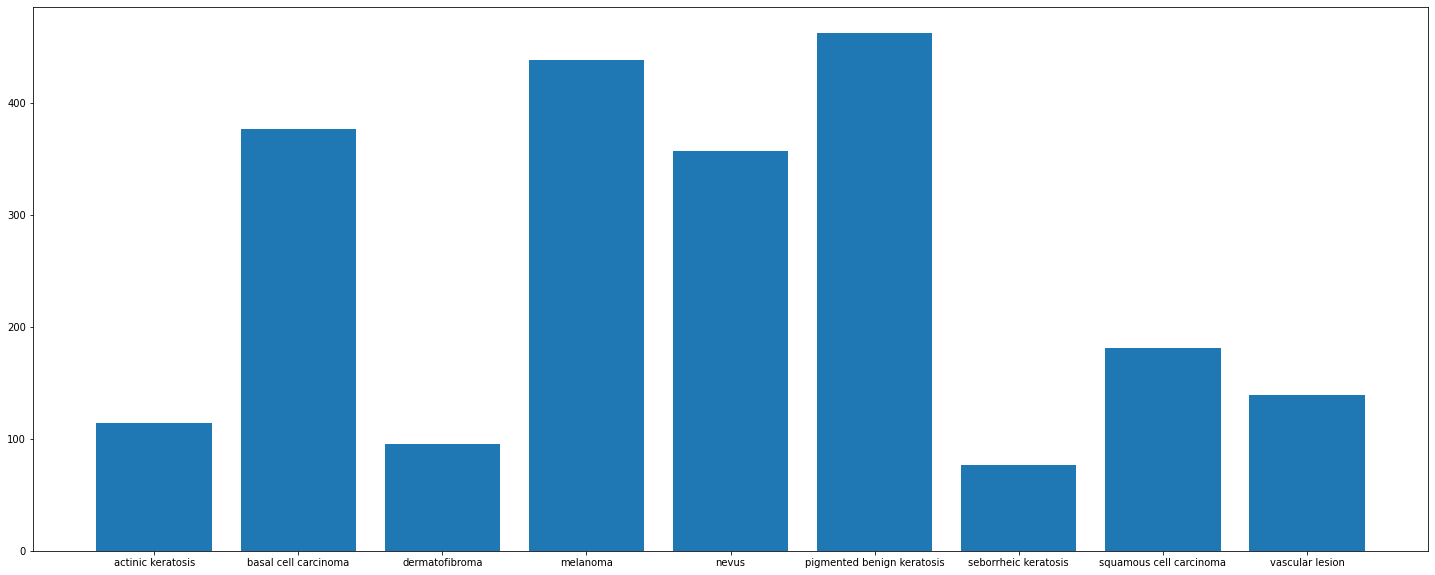

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**squamous cell carcinoma** has least number of samples

**actinic keratosis and dermatofibroma** have proportionate number of classes.

**melanoma and pigmented benign keratosis** have proprtionate number of classes

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### Rectify the class imbalance
#### Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
#path_to_training_dataset="/content/drive/MyDrive/Skin_cancer_ISIC/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/Skin_cancer_ISIC/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A421FB6D0>: 100%|██████████| 500/500 [00:55<00:00,  8.93 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A4215E1D0>: 100%|██████████| 500/500 [00:46<00:00, 10.83 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A42031FD0>: 100%|██████████| 500/500 [00:47<00:00, 10.46 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5A42160B10>: 100%|██████████| 500/500 [00:45<00:00, 10.89 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7F5A44244B50>: 100%|██████████| 500/500 [00:47<00:00, 10.63 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A43CF9190>: 100%|██████████| 500/500 [00:42<00:00, 11.82 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A42026D10>: 100%|██████████| 500/500 [00:46<00:00, 10.71 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A420BE990>: 100%|██████████| 500/500 [00:48<00:00, 10.41 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_cancer_ISIC/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F5A42155190>: 100%|██████████| 500/500 [00:43<00:00, 11.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Now check the total count of augmented images.

In [ ]:
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/Skin_cancer_ISIC/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)


4500


In [ ]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
1,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
2,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
3,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
4,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,actinic keratosis
...,...,...
6734,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
6735,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
6736,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion
6737,/content/drive/MyDrive/Skin_cancer_ISIC/Train/...,vascular lesion


### The distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

[]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

[]

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1343
melanoma                      1337
basal cell carcinoma          1118
nevus                         1080
squamous cell carcinoma        566
vascular lesion                437
actinic keratosis              344
dermatofibroma                 289
seborrheic keratosis           225
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
import pathlib
data_dir_train1=pathlib.Path("/content/drive/MyDrive/Skin_cancer_ISIC/Train")

In [ ]:
data_dir_train1

PosixPath('/content/drive/MyDrive/Skin_cancer_ISIC/Train')



#### Create a training dataset

In [ ]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
## Use of Dropout layer to check the evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### Compile the model (Choosen optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train model

In [ ]:
epochs =20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 11s 193ms/step - loss: 2.0773 - accuracy: 0.1836 - val_loss: nan - val_accuracy: 0.6726
Epoch 2/20
56/56 [==============================] - 10s 186ms/step - loss: 2.0359 - accuracy: 0.1836 - val_loss: nan - val_accuracy: 0.0564
Epoch 3/20
56/56 [==============================] - 10s 185ms/step - loss: 2.0268 - accuracy: 0.1842 - val_loss: nan - val_accuracy: 0.6719
Epoch 4/20
56/56 [==============================] - 10s 186ms/step - loss: 2.0251 - accuracy: 0.2104 - val_loss: nan - val_accuracy: 0.6652
Epoch 5/20
56/56 [==============================] - 10s 185ms/step - loss: 1.9709 - accuracy: 0.2533 - val_loss: nan - val_accuracy: 0.3734
Epoch 6/20
56/56 [==============================] - 10s 184ms/step - loss: 1.9599 - accuracy: 0.2372 - val_loss: nan - val_accuracy: 0.6667
Epoch 7/20
56/56 [==============================] - 10s 185ms/step - loss: 1.9760 - accuracy: 0.2327 - val_loss: nan - val_accuracy: 0.6696
Epoch 8/20
56/56 [=============

#### Visualizing the model results

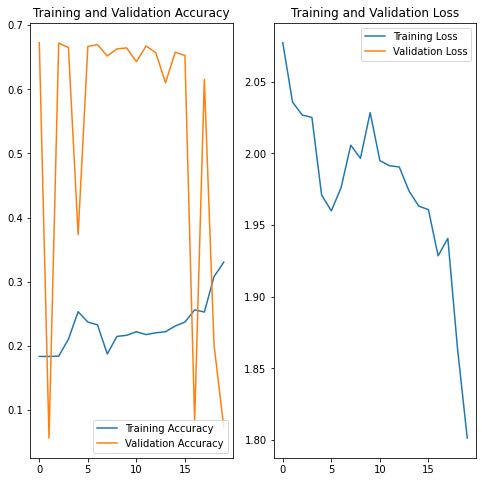

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Result analysis to verify wether the result got rid of underfitting/overfitting and did class rebalance help?



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter